# Introduction

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The housing market is a large and profitable industry. Many people make a fortune just by flipping houses. So the question arose: can we create an accurate, predictive model to determine the potential marketability of a house? And what features of a house play the biggest role in its marketability? After a fair amount of research we discovered that *Zillow.com* does exactly that. They provide an estimate of the price a house should be listed at. They even provide research statistics on houses in any given state or area, but they provide none of the data or methods involved.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Knowing that it is possible to create predictive models of house marketability, we set out to do it by finding reliable data on recently sold houses. Important features of a house we need for proper analysis included the selling price, initial listing price, house size, lot size, location, time on the market, and the number of bedrooms and bathrooms. After searching through housing market websites that contained these features on recently sold houses, we settled on the website *estately.com*. This website provides real-time updates on houses in the US. They also provide a tour service by connecting customers to local agents. This finding provided us with reliable and promising data that we used to analyze what features to use in a predictive model.

# Data Collection

## Scraping

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Starting with our idea to scrape sites for sold houses, we looked at Zillow, Redfin, MLS, and more, but all of them either disallowed what we wanted or prohibited scraping on their site. Finally, we found *estately.com*. They were very generous in allowing us to scrape anything on sold houses, so we wrote a DFS using selenium to crawl the site. It started out on the state we wanted information from, clicked into each city link, applied the single-family house filter, clicked on each  house link, scraped the necessary information, navigated back, and continued that way until every house in every city in the state we specified was scraped. To optimize spacial complexity, we saved all of the housing data per city as a csv file as we went. We scraped houses from Colorado, Nevada, California and Arizona. Running the script took about 54 hours. Getting the information we wanted required a lot of parsing through text using regular expressions. Luckily, most of the data we wanted was all in the same format. Here is a snippet from the script:

In [ ]:
#scraping_estately.py
def regexFind(reText,line,first=True):
    """finds text in the given line"""
    finder = re.compile(reText)
    locatedText = finder.findall(line)
    if len(locatedText) == 0:
    #if we couldn't find anything, return nan
        locatedText = np.nan
    else:
        if first:
            locatedText = locatedText[0]
    return locatedText
    
def ParseListingDeets(listingDeets):
    """
    Uses RegEx to parse through the listing details 
    They looks like this:
         '5 beds 3 baths 1,841 sqft 8,057 sqft lot 
         $23 per sqft 1972 build 115 days on site'
    returns a list of the info
    """
    #find the bed portion
    beds = regexFind('(.+?) bed',listingDeets)   
    #find the bath portion
    baths = regexFind('bed.? (.+?) bath',listingDeets)  
    #find the house size
    hsize = regexFind('bath[a-z]{,1} (.*?) sqft',listingDeets)
    #find the lot size
    lsize = regexFind('sqft (.*?) lot',listingDeets)       
    #find the year built
    year = regexFind('([0-9]{4}) build',listingDeets)       
    
    return [beds,baths,hsize,lsize,year]   

**Problems:**

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Occasionally, selenium would not wait long enough for the page data to load, so it threw an error. We handled it by waiting for a few seconds and trying again, but sometimes this still was not long enough. At that point the script stopped scraping the data from that city. This happened once every ~5,000 houses. Since some cities that had more data are not represented well in our data set, this will probably introduce a slight bias from city to city. However, we do not anticipate this error to affect our overall results since on average, only 40 houses were missed per city. Out of the ~58,000 data points accumulated, this amounts to missing ~464 houses overall--less than 1%.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We realized that many of the features were scraped incorrectly our first time through. For example, sometimes the number of bathrooms were listed as 2.5, and our web crawler would scrape only the 5. We also misinterpreted the "days on site" value. We initially thought it meant "date posted on site", but as we visualized our data, we realized that it meant "today's date minus when it was posted". Small changes to the scraper and another 154 hours yielded correct information. The second scraping took so long due to unforeseen interruptions such as network outages, students turning off the computer, and so on.

## Cleaning

### Initial Data Manipulation:

After re-scraping, we needed to concatenate the hundreds of csv files the web crawler generated. We did that by extracting all the data from each file from each state, then concatenated them into one large PANDAS DataFrame.

After importing our data, we found a couple of problems:
    1. The lot sizes were in both sq. ft. and acres.
    2. Some of the zip code values contained county names.
    3. Some of the data contained empty strings or dashes and some of the rows were completely empty or had corrupt information

### Cleaning Up Our Data:

The solutions to these problems ranged in difficulty:

#### Lot Sizes:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We queried the data and found every entry that contained the string "sqft" and determined the conversion from square feet to acres (1 acre == 43560 sq. ft.). Using regular expressions, we isolated the numbers, converted them to acres, and replaced the entry with our converted value. Some of the listings were also in fraction form (e.g. 1/2 acre) and some had approximated values (e.g. ~1 acre). We converted the fractions to decimals and rounded the approximated values (e.g. 1/2 to 0.5 and ~1 to 1). These changes were implemented in the following function:

In [2]:
#Clean&Feature_Engineer.py
def sqftToAcre(df): # takes in a DataFrame as input
    '''
    A function that converts Sq. Ft. units to acres for a Pandas DataFrame, 
    assuming there is a column named 'LotSize'.    
    Input:
        df: pd.DataFrame()) -- DataFrame that contains the column 
                               df['LotSize'] with units 'sqft' and 'acres'    
    Output:
        returns the updated DataFrame with the 'LotSize' column in acres only
    '''
    sqftConverter = 43560                                                 
    for index, row in df.iterrows():
        # checks if the entry is in sqft or acres
        if row['LotSize(acre)'].find('sqft') != -1:  
            # pulls the digits out of the string
            x = [int(s) for s in re.findall(r'\b\d+\b', row['LotSize (acre)'])]
            # concotenate and converts the number
            num = round(int(''.join(map(str,x)))/sqftConverter,2)  
            newval = '~'+str(num)+' acre'
            row['LotSize(acre)'] = str(newval
        # fractions
        elif row['LotSize(acre)'].find('/') != -1:                       
            x = [s for s in re.findall(r'\d.*\d', row['LotSize (acre)'])] 
            # size is less than 1 acre (just the fraction)
            if len(x) == 3:                                               
                num = round(int(x[0])/int(x[-1]),3)
                row['LotSize(acre)'] = float(str(num))
            # size is reater than 1 acre (mixed fraction)
            elif len(x) > 3:                                              
                x2 = [s for s in re.findall(r'\b\d+\b', x[:-3])]
                num = int(x2) + round(int(x[-3])/int(x[-1]),3)
                row['LotSize(acre)'] = float(str(num))
        # decimals
        elif row['LotSize(acre)'].find('.') != -1:                     
            x = [s for s in re.findall(r'\d.*\d', row['LotSize (acre)'])]
            num = round(float(x),3)
            row['LotSize(acre)'] = float(str(num))
        # integer estimate
        elif row['LotSize(acre)'].find('~') != -1:                       
            x = [s for s in re.findall(r'\d.*\d', row['LotSize (acre)'])]
            num = round(float(x),3)
            row['LotSize(acre)'] = float(str(num))
    return df

#### Zip Codes:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We decided that deleting the listings that contained county names instead of zip codes was for the best. We reasoned that it was simpler to remove those listings, since only 98 total listings had this problem. The fact that this only happened in 3 cities essentially removed those cities from our data set. We determined that the omission bias that this might cause would be somewhat insignificant.
        
#### Missing Data:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;There was not enough data to merit keeping some of the features (i.e. middle and high school ratings for the area, and the internet speed of the house), so we dropped them. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Several rows had many missing or erroneous data. We filled the missing data with NANs, averages, or dropped the rows. We completely dropped the totally empty rows and the rows with NANs in the elementary school ratings and year built features. We chose these features because they were the only ones with NAN values. We considered re-scraping the data we dropped, but after the lengthy second re-scraping, we decided that dropping them was the better choice due to time constraints.

In [ ]:
#Clean&Feature_Engineer.py
# missing 39802 data points
df = df.drop(['InitialPrice'], axis=1)
# data is corrupt
df = df.drop(['WalkScore'], axis=1)
# missing 2067 data points (and unnecessary)
df = df.drop(['InternetSpeed'],axis=1)
# missing 6514 data points
df = df.drop(['MiddleSchoolRating'], axis=1)
# missing 13450 data points, so we're taking it out
df = df.drop(['HighSchoolRating'], axis=1)
#replace empty values or corrupt values with NANs
df.replace("",np.nan,inplace=True)
df.replace("–",'1',inplace=True)
df.Stories.replace('5+','5',inplace=True)
#then drop the NANs in columns that we'll need
df=df.dropna(subset=['YearBuilt'])
df=df.dropna(subset=['ElementarySchoolRating'])

# Feature Engineering

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We first extrapolated the feature "DaysOnMarket" from the date posted and the date sold features. If either one of those features were missing, we used the average number of days a house is on the market as computed by Zillow, dependent on the state the house resides in. This happened to ~2,000 houses. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In order to facilitate and simplify the process for analyzing our data, we one-hot encoded the featuers "Forclosed" and "State". We decided not to one-hot encode the features "City" and "Zipcode". Doing so would increase our number of features to ~900, which might cause our regression to over-fit the data, and these extra features would only tell us which cities or zip codes weighed into our analysis.

In [ ]:
#Clean&Feature_Engineer.py
#one-hot encode foreclosed and state
df = pd.get_dummies(df,drop_first=True,columns=['Foreclosed'])
df = pd.get_dummies(df,drop_first=True,columns=['State'])

# Data Visualization

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;After feature engineering, the next step was to visually represent what house features played the biggest role in determining how marketable it was. We based the marketability of a house on mainly two features: selling price and selling time.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Although the idea was clearly set, it wasn't very clear how to determine what features correlated with others. Through simple data visualization and linear regression models, we discovered some interesting correlations.

## Plotting Year Built vs Price Sold:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;One interesting correlation came from visualizing our data in a Hexbin. We saw that the highest density and concentrations of sold houses fell between a range of about 1995-2008 and then again after 2015. However, we also realized that our data had a notable overlap between foreclosed and non-foreclosed homes, most likely caused by the housing bubble of 2008. We decided to group our data into 2 subcategories: foreclosed houses and houses sold on the regular market.

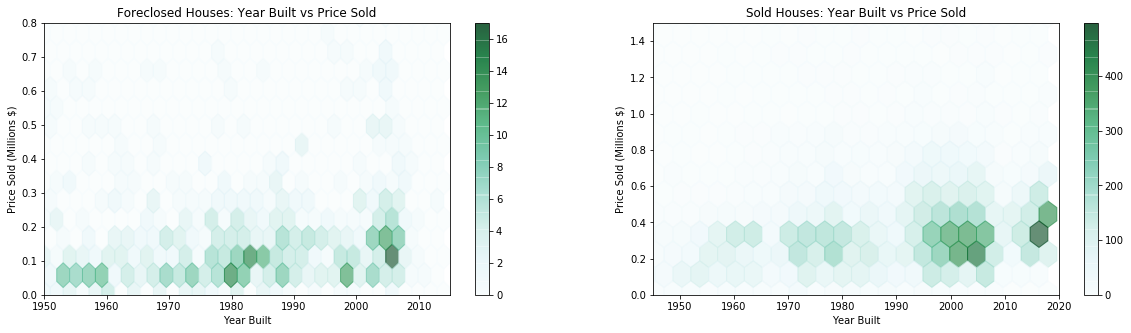

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The distinction between the two groups is very apparent. We see from the foreclosed houses that a large concentration of houses were built in the late 1990's and then again in the mid 2000's. As seen with the sold houses, the vast majority that were not sold through foreclosure were built in the early 2000's and then again around 2016. Seeing this made us question if houses sold better in some years than others.

## Plotting Year Built vs Foreclosure:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Keeping with the previous strategy, we separated our housing data into foreclosure sales and normal market sales.

In [ ]:
<img src="dvis.png">

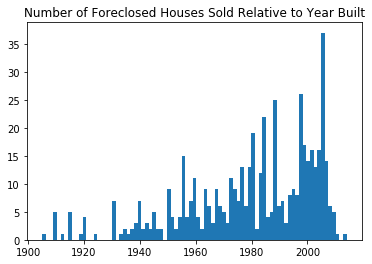

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;An interesting takeaway from this is the large spike of foreclosed houses sold that were built in the early to mid 2000's. This seems to tell us that an unusual amount of people built houses in the early 2000's, possibly stemming from the superficial appearance of a stable and booming housing market. We also see that the data history. When the housing recession hit in 2008, banks foreclosed on many homes, which explains the spike of foreclosed homes around that time.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Another interesting fact to note is the differences of trends between the graphs. There's a large spike of houses purchased on the market that were built in the late 1990's to early 2000's, possibly arising from wanting to sell at peak price. We also see that during the housing recession years (from about 2006-2008) there are very few houses that were built and sold. Coming out of those recession years would explain why we see a large spike in houses from the 2010's that are being built, sold, and not foreclosed on.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We also note the volume of houses being built and sold in 2018 is about 10 times more than the volume of houses that were built pre-1960. This could be from an expanding population, along with natural deterioration of older houses. 

## Plotting Sold Price and Days On Market Densities by State:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, we compared the market time of houses based on their location. We consider that a state-based bias could occur from differences in data amount between states.

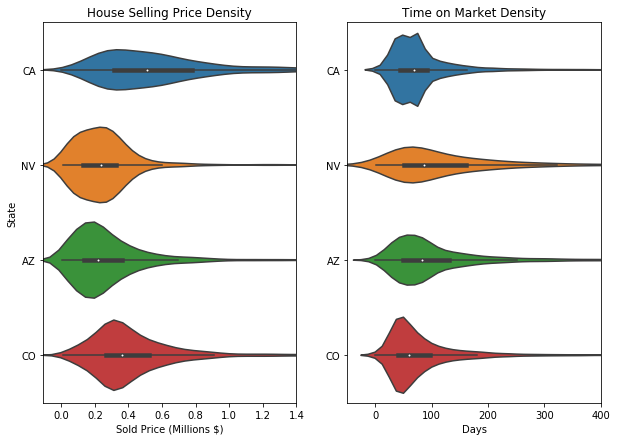

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We see that the distribution of housing prices is much wider in California than those of the other states. This is most likely caused by higher than average house prices in California compared to other states. However, we do note that the mean house price between the states, excluding California, are within about $100,000 of each other.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We were able to gain some more understanding on other trends between these neighboring states. For example, houses tend to be on the market for about 50-60 days, regardless of the location. 

## Plotting School Ratings vs Sold Prices

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; As shown in our concluding visuals, we ran a simple linear regression on sold prices of houses based on nearby elementary school ratings to determine if there was some sort of correlation between the two.

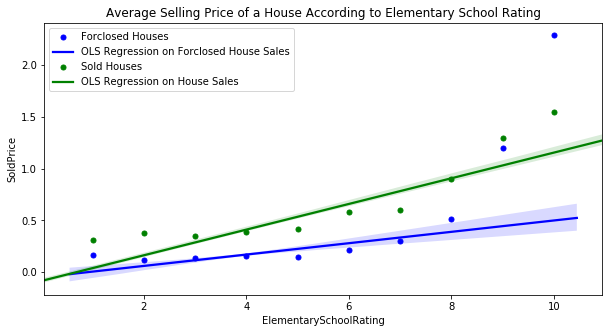

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We recognize that a linear fit is not the best model for this data, as the average house price by school rating increased exponentially. This appears to be an indicator that the quality of elementary schools play a factor in determining the price a house is sold at.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Our analysis of this is that either the houses that are more expensive are located in better communities or neighborhoods, or families are more willing to spend more on a house in order to offer their children the best education. Thus, houses might be sold at higher prices around better elementary schools because those buying them may see it as an investment in their child's education.

## Plotting School Ratings vs Days on Market

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Next, we checked how the rating of elementary schools affected the time a house was on the market. We regressed on the days on market feature, and plotted our findings.


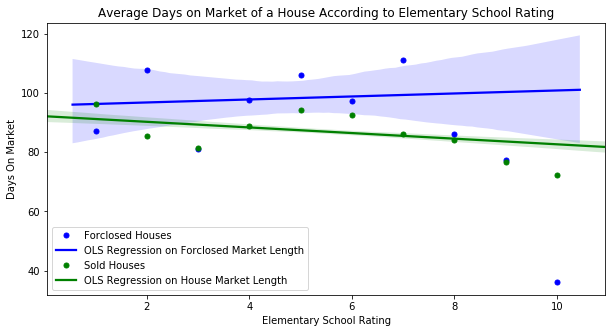

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Notice another slight trend: as the elementary school ratings increased, the houses around those areas sold faster.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We concluded that parents seem to prefer houses closer to higher quality elementary schools. Thus, not only were houses sold at higher prices around those schools, they were also sold faster. It seems that elementary schools either have a fairly notable influence on the success of a house on the market, or indicate that higher quality schools are surrounded by more desirable houses.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Lastly, we note that a linear fit for elementary school ratings' on foreclosed house sales is not preferable, compared to a parabolic fit.

# Analysis

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;After finishing our data visualizations, we determined the predictive accuracy of our models. We ran an OLS regression on sold price against the rest of the quantifiable features. After removing every feature that had a p-value less than 0.05, we found that 7 of the features were statistically significant, and had an $R^2$ value of 0.022. We did the same thing for the days on the market and found that 11 of the features were statistically significant, and had an $R^2$ value of 0.048. The low $R^2$ values could mean that the data is not linear, which is what we saw in our visualizations.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;We minimized the AIC and BIC values for the linear regression on selling price and returned the subset of features that minimized these indicators. The features that gave an optimal AIC were bedrooms, bathrooms, house size, year built, the elementary school rating, and the days on the market. These are the best predictors of selling price. The features that minimized the BIC were bathrooms, house size, year built, and the elementary school rating. In a model to predict optimal selling price, we would use these features. 



# Conclusion

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;The predictive indicators we found gave us a good start on creating a model for optimal house marketability. We found correlations between selling price and other features in the data set. For example, we learned that the proximity to higher quality elementary schools yielded higher selling prices and faster selling time. From our regression models, we determined that elementary school ratings were a statistically significant indicator of selling price and selling time. It may be possible to extend this same correlation to both middle school and high school ratings. We could verify this with more data.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Some of our features were also inaccurately modeled by linear regression. In future work, we would want to run a multidimensional regression on selling price and days on market and find the minimized AIC and BIC values for them to create a better model. Using k-fold cross validation techniques would help to determine features that impact the selling price of a house and its time on the market the most. In the end, these techniques would allow us to finish building an accurate predictive model of the marketability of a house.